In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
import ipywidgets as widgets
from IPython.display import clear_output


def get_image(filename='img/house2.png'):
    image = cv2.imread(filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image

def plot_image(image):
    fig, ax = plt.subplots(1, 1, figsize=(12, 7))
    ax.imshow(image, cmap='gray')
    plt.show()

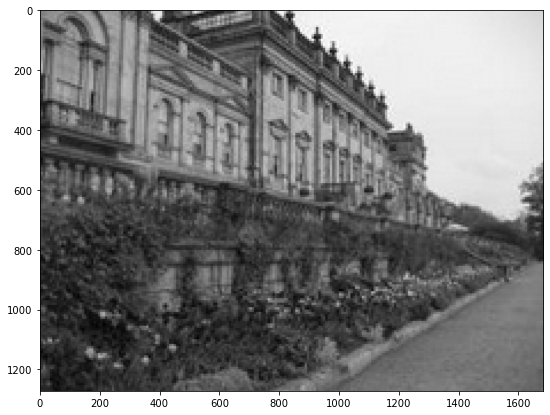

In [4]:
original_image = get_image()
plot_image(original_image)

IntSlider(value=2, continuous_update=False, description='Test:', max=32, min=2)

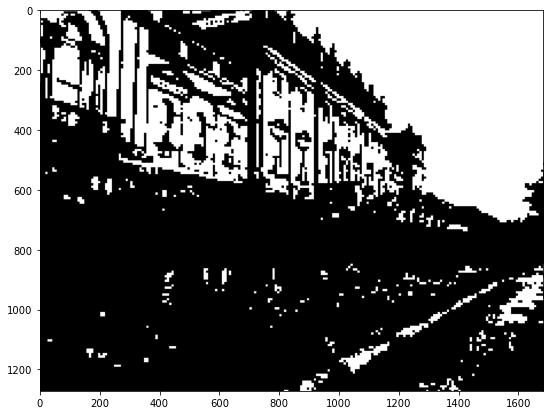

In [5]:
slider = widgets.IntSlider(
    value=2,
    min=2,
    max=32,
    step=1,
    description='Test:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
display(slider)


def quantorize(image, levels: int):
    height = round(255 / levels)
    quant = np.vectorize(lambda x: x - x % height + int(height / 2))
    image = quant(image)
    return image



def on_value_change(change):
    clear_output(wait=True)
    display(slider)
    image = get_image()
    plot_image(quantorize(image, change['new']))
        

slider.observe(on_value_change, names='value')

on_value_change({'new': 2})

Otsu's method threshold 144 level


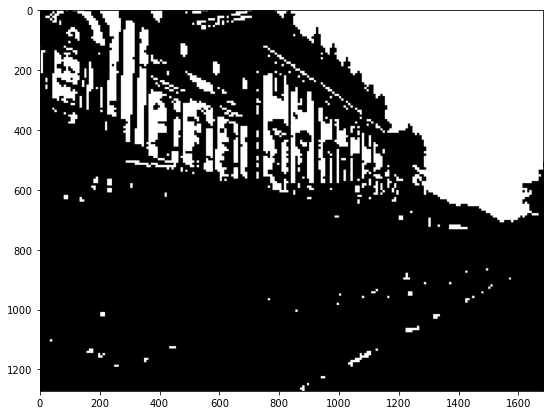

In [6]:
def threshold(image, threshold):
    image[image > threshold] = 255
    image[image <= threshold] = 0
    return image

def find_otsu(image):
    hist, _ = np.histogram(image, bins=256)
    pixels_count = len(image) * len(image[0])
    return otsu_method(hist, pixels_count)


def otsu_method(hist, pixels_count, start=0, end=256):
    # считаем сумму интенсивности всех пикселей
    intensity_sum = 0
    for i in range(start, end):
        intensity_sum += i * hist[i]
    
    # сигма это что-то типо отличия двух половинок гистограммы
    maximum_sigma = 0
    # это порог
    threshold = 0
    
    # количество пикселей в левой части гистограммы
    first_class = 0
    # сумма интенсивности левой части
    first_class_intensity_sum = 0
    
    # по всем бинам гистограммы идем. от 0 до i - левая часть изображения, i до 255 правая
    for i in range(start, end):
        # инкримент количества пикселей
        first_class += hist[i]
        # инкримент интенсивности (i это цвет, hist[i] количество пикселей этого цвета,
        # i * hist[i] интенсивность)
        first_class_intensity_sum += i * hist[i]
        
        # защита от первого и последнего бина
        if first_class == 0 or first_class == pixels_count:
            continue
        
        # вероятность того, что случайный пиксель попадет в левую часть изображения
        first_class_probability = first_class / pixels_count
        # аналогично для правой части
        second_class_probability = 1 - first_class_probability
        
        # количество пикселей правой части
        second_class = pixels_count - first_class
        # их сумма интенсивностей
        second_class_intensity_sum = intensity_sum - first_class_intensity_sum
        
        # среднее значение интенсивности для пикслея из каждой части изображения
        first_class_mean = first_class_intensity_sum / first_class
        second_class_mean = second_class_intensity_sum / second_class
        
        
        delta = (second_class_mean - first_class_mean) ** 2
        # разница между двумя половинками. значение i при котором сигма максимально - есть порог Отцу
        sigma = first_class_probability * second_class_probability * delta
        
        if sigma > maximum_sigma:
            threshold = i
            maximum_sigma = sigma
        
    return threshold

def global_threshold():
    image = get_image()

    otsu_threshold = find_otsu(image)
    print(f"Otsu's method threshold {otsu_threshold} level")
    
    return threshold(image, otsu_threshold)


plot_image(global_threshold())

Threshold for 1 image 158, threshold for 1 image 90


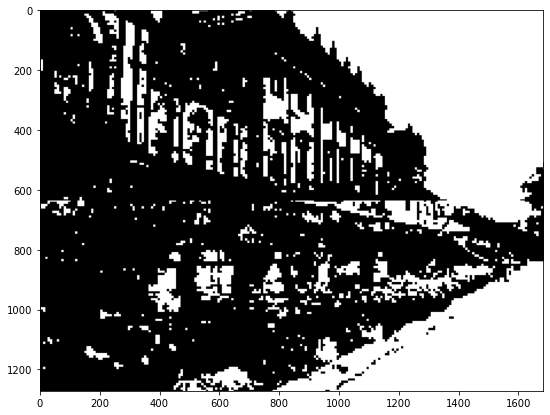

In [7]:
def find_local_otsu(image):
    half_height = int(len(image) / 2)
    half_width = int(len(image[0]) / 2)
    
    images = [
        image[:half_height], 
        image[half_height:]
    ]
    
    thresholds = [find_otsu(images[0]), find_otsu(images[1])]
    
    return images, thresholds


def concat_images(image1, image2):
    return np.concatenate((image1, image2), axis=0)

    
def apply_threshold(images, thresholds):
    return list(map(lambda x: threshold(*x), zip(images, thresholds)))


def local_threshold(image):
    images, thresholds = find_local_otsu(image)
    images = apply_threshold(images, thresholds)
    thresholded = concat_images(*images)
    print(f'Threshold for 1 image {thresholds[0]}, threshold for 1 image {thresholds[1]}')
    
    return thresholded


plot_image(local_threshold(get_image()))

In [28]:
def recursive_otsu(hist, pixel_count, start=0, end=256):
    # метод рекурсивный. на каждом шаге ты запускаешь отцу по куску гистограммы
    otsu = otsu_method(hist, pixel_count, start, end)
    
    levels = [otsu]
    
    # условие остановки рекурсии
    # если количество бинов, которые мы хотим обработать меньше 65, то заканчиваем
    # выбрано именно это число просто так
    if (abs(otsu - start)) > 80: 
        pixel_count = hist[start:otsu].sum()
        # эм. тут ошибка. пикселей в бинах совершенно не обязательно именно столько. это мой косяк
        levels += recursive_otsu(hist, pixel_count // 2, start=start, end=otsu)
        
    if (abs(end - otsu)) > 80: 
        pixel_count = hist[otsu:end + 1].sum()
        levels += recursive_otsu(hist, pixel_count // 2, start=otsu, end=end)
    
    return levels


def hierarchy_threshold(image):
    # подготовка параметров для запуска алгоритма
    hist, _ = np.histogram(image, bins=256)
    pixels_count = len(image) * len(image[0])
    
    # запуск
    levels = sorted(set(recursive_otsu(hist, pixels_count)))
    
    # покраска
    colors = []
    previous_level = 0
#     print(levels)
    for level in levels:
        colors.append(previous_level + (level - previous_level) // 2)
        previous_level = level
#     print(hist)
#     print(levels)
    
    return levels, colors

Amount of levels = 4, ([75, 144, 168, 229])


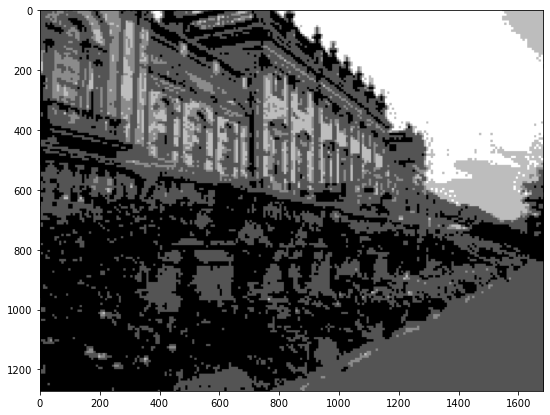

In [29]:
def quantorize_by_levels(image, thresholds, colors):
    thresholds = [0] + thresholds
    lut = [255 for _ in range(256)]
    for i in range(len(thresholds) - 1):
        down = thresholds[i]
        up = thresholds[i + 1]
#         print(i, down, up, colors[i])
        for j in range(down, up):
            lut[j] = colors[i]
        
    image = np.vectorize(lambda x: lut[x])(image)
    return image


def on_value_change():
    image = get_image()
#     plot_image(image)
    levels, colors = hierarchy_threshold(image)
    quanted_image = quantorize_by_levels(image, levels, colors).astype('uint8')
    print(f'Amount of levels = {len(levels)}, ({levels})')
    plot_image(quanted_image)
#     red_channel = np.full_like(quanted_image, 127)
#     blue_channel = np.full_like(quanted_image, 117)
    
#     merged = cv2.merge((blue_channel, quanted_image, red_channel))
#     plt.imshow(cv2.cvtColor(merged, cv2.COLOR_BGR2RGB))
#     plt.imshow(quanted_image, cmap='gray')
    
    
        
        
on_value_change()